# A Quantitative Estimation of Reviews from Medical Test Subjects

## Introduction
Testing of new medicine from medical companies is a complex and long process, as you have to check for both short-term and long-term side effects. On top of that human test subjects are needed in the final testing phase of the medicine, making the process both very long and expensive if sufficient statistics has to be obtained. Furthermore the reviews from human test subjects are often not quantitative but qualitative with text descriptions rather than ratings. In this project I try to make an algorithm to translate the qualitative descriptions from the human test subjects to quantitative ratings in order to better and faster conclude on the quality of new medicine to be tested. For this purpose I use already labelled data from drugs.com extracted by by Surya Kallumadi (Kansas State University) and Felix Grässer (Technical University of Dresden). The dataset has 3,100 reviews and labels (Review score from 1-10). I will try to build a predictor of the ratings based on those text reviews. If successful the project can be presented for institutional organisations that 1) determines the quality of new medicine and 2) carries out the testing on human subjects.

## ETL Script
Files were already divided into a trainig and a test dataset, and they were renamed to training_data.tsv (75 % of the data) and test_data.tsv (25 %) for convenience.

In [1]:
# import important libraries
import os
import pandas as pd
import numpy as np

# set a limit of printing an array
np.set_printoptions(threshold=10)

# read training and test data. It turned out that .tsv files can be read as csv-files by pandas by specifying the separation by '\t'
training_data_path = '/Users/petervester/Downloads/drugLib_raw/training_data.tsv'
test_data_path = '/Users/petervester/Downloads/drugLib_raw/test_data.tsv'
training_df = pd.read_csv(training_data_path, sep='\t', index_col=0)
test_df = pd.read_csv(test_data_path, sep='\t', index_col=0)

pd.set_option('display.max_colwidth', -1)
training_df.head(3)

,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dysfunction into overt heart failure \r\r\nalone or with other agents in the managment of hypertension \r\r\nmangagement of congestive heart failur,"cough, hypotension , proteinuria, impotence , renal failure , angina pectoris , tachycardia , eosinophilic pneumonitis, tastes disturbances , anusease anorecia , weakness fatigue insominca weakness","monitor blood pressure , weight and asses for resolution of fluid"
3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,"Although this type of birth control has more cons than pros, it did help with my cramps. It's also effective with the prevention of pregnancy. (Along with use of condoms as well)","Heavy Cycle, Cramps, Hot Flashes, Fatigue, Long Lasting Cycles. It's only been 5 1/2 months, but i'm concidering changing to a different bc. This is my first time using any kind of bc, unfortunately due to the constant hassel, i'm not happy with the results.","I Hate This Birth Control, I Would Not Suggest This To Anyone."
1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,"I was used to having cramps so badly that they would leave me balled up in bed for at least 2 days. The Ponstel doesn't take the pain away completely, but takes the edge off so much that normal activities were possible. Definitely a miracle medication!!",Heavier bleeding and clotting than normal.,"I took 2 pills at the onset of my menstrual cramps and then every 8-12 hours took 1 pill as needed for about 3-4 days until cramps were over. If cramps are bad, make sure to take every 8 hours on the dot because the medication stops working suddenly and unfortunately takes about an hour to an hour and a half to kick back in.. if cramps are only moderate, taking every 12 hours is okay."


First of all, we take a look at the number of rows, the datatypes and other information of the training dataset.

In [2]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3107 entries, 2202 to 2748
Data columns (total 8 columns):
urlDrugName          3107 non-null object
rating               3107 non-null int64
effectiveness        3107 non-null object
sideEffects          3107 non-null object
condition            3106 non-null object
benefitsReview       3107 non-null object
sideEffectsReview    3105 non-null object
commentsReview       3099 non-null object
dtypes: int64(1), object(7)
memory usage: 218.5+ KB


In [3]:
melted = pd.melt(training_df)
pd.crosstab(index=[pd.notnull(melted['value'])], columns=[melted['variable']])

variable,benefitsReview,commentsReview,condition,effectiveness,rating,sideEffects,sideEffectsReview,urlDrugName
value,,,,,,,,
False,0,8,1,0,0,0,2,0
True,3107,3099,3106,3107,3107,3107,3105,3107


From the information above, we can see that the numbers of rows of are not equal for every column. This is because some columns contain NaN values. The next step is to remove NaN values by in-built function sin Pandas. Well, I might not might not strightly have to drop the rows, but it's very little data. Let's drop it for now

In [4]:
# for the training data
training_df.dropna(inplace=True)
training_df.info()

# also for the test data
test_df.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3096 entries, 2202 to 2748
Data columns (total 8 columns):
urlDrugName          3096 non-null object
rating               3096 non-null int64
effectiveness        3096 non-null object
sideEffects          3096 non-null object
condition            3096 non-null object
benefitsReview       3096 non-null object
sideEffectsReview    3096 non-null object
commentsReview       3096 non-null object
dtypes: int64(1), object(7)
memory usage: 217.7+ KB


It seemed to work very well, now all the columns have the same number of rows and we still have 3,096 data rows.

Some simple statistics about the data, using the built-in function in Pandas dataframes.

In [5]:
training_df.describe(include='all')

,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
count,3096,3096.000000,3096,3096,3096,3096,3096,3096
unique,501,NaN,5,5,1422,3021,2806,3044
top,lexapro,NaN,Highly Effective,Mild Side Effects,depression,none,none,none
freq,63,NaN,1327,1017,236,20,111,6
mean,NaN,7.010659,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,2.936630,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,8.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN


Now, to increase our understanding of the dataset. Firstly, we take a look at the rating score and find its min and max value. Then, we make a survey of the 'effectiveness', 'sideEffects', and 'condition' columns about their values and data types. According to the sample data above, it seems like both 'effectiveness' and 'sideEffects' columns are categorical. What we would like to know is whether condition is also categorical.

In [6]:
print('rating min: {0}, rating max: {1}'.format(training_df['rating'].min(), training_df['rating'].max()))

print('unique values in \'rating\':')
print(training_df['rating'].unique())

print('unique values in \'urlDrugName\':')
print(training_df['urlDrugName'].unique())

print('unique values in \'effectiveness\':')
print(training_df['effectiveness'].unique())

print('unique values in \'sideEffects\':')
print(training_df['sideEffects'].unique())

print('unique values in \'condition\':')
print(training_df['condition'].unique())

rating min: 1, rating max: 10
unique values in 'rating':
[ 4  1 10  3  2  9  7  8  6  5]
unique values in 'urlDrugName':
['enalapril' 'ortho-tri-cyclen' 'ponstel' ... 'glucophage-xr'
 'risperdal-consta' 'trileptal']
unique values in 'effectiveness':
['Highly Effective' 'Marginally Effective' 'Ineffective'
 'Considerably Effective' 'Moderately Effective']
unique values in 'sideEffects':
['Mild Side Effects' 'Severe Side Effects' 'No Side Effects'
 'Extremely Severe Side Effects' 'Moderate Side Effects']
unique values in 'condition':
['management of congestive heart failure' 'birth prevention'
 'menstrual cramps' ... 'hives, itching, swelling due to allergies'
 'muscle relaxant - spinal disorder' 'total hysterctomy']


The values of 'rating' contain only 1-10 with no NaN values. So, we do not have to worry about NaN values in this column.

We can observe that the values in condition could be just descriptive text from patients instead of categorical data. To clarify this, we count the number of unique values and compare it with the number of rows of the dataset. If the 'condition' column has the same number of unique values as the total rows, then it is considered text description.

In [7]:
print('row count: {}'.format(training_df.shape[0]))
print('number of unique values in \'urlDrugName\': {}'.format(len(training_df['urlDrugName'].unique())))
print('number of unique values in \'condition\': {}'.format(len(training_df['condition'].unique())))

row count: 3096
number of unique values in 'urlDrugName': 501
number of unique values in 'condition': 1422


It seems like the values in 'condition' are a very big categorical data field consisting of nearly half of the total rows. We can also observe that there are 502 types of drugs but 1427 values of the conditions. This means that one drug can be used to treat more than one condition.

## Data Cleaning

First of all, we have some rows that contain 'see above' comments which refer to one of the other review columns for the same sample ID. If we lumps all the review columns together in one field, that field will also include the column that precedes it. This will also increase the information context per feature in the analysis. The 'see above', 'none' reviews should be taken care by replacing them with a blank string.

In [8]:
# import important packages
from sklearn.preprocessing import OneHotEncoder

### Emptry String Cleaning

In [9]:
# lower the text to remove empty string representatives
training_df['benefitsReview'] = training_df['benefitsReview'].str.lower()
training_df['sideEffectsReview'] = training_df['sideEffectsReview'].str.lower()
training_df['commentsReview'] = training_df['commentsReview'].str.lower()

# drop rows that contain 'none' value in condition
none_condition_rows = len(training_df[training_df['condition'].apply(lambda x: str(x) == 'none')])
if none_condition_rows > 0:
    training_df.drop(training_df[training_df.condition == 'none'].index, inplace=True)

# it seems that there is a problem about return lines ('\r' and '\n') replace all of \r's with white space
new_line_chars = ['\r', '\n']
training_df.benefitsReview.replace(to_replace=new_line_chars, value=' ', regex=True, inplace=True)
training_df.sideEffectsReview.replace(to_replace=new_line_chars, value=' ', regex=True, inplace=True)
training_df.commentsReview.replace(to_replace=new_line_chars, value=' ', regex=True, inplace=True)

# replace all of 'none' comments in all review columns with empty string
non_comments = ['none', 'see above', 'NaN', 'NA', np.nan]
training_df.benefitsReview.replace(to_replace=non_comments, value=' ', regex=True, inplace=True)
training_df.sideEffectsReview.replace(to_replace=non_comments, value=' ', regex=True, inplace=True)
training_df.commentsReview.replace(to_replace=non_comments, value=' ', regex=True, inplace=True)

# combine all the review comments together for NLP
training_df['combinedReview'] = training_df['benefitsReview'].astype(str) + '' + training_df['sideEffectsReview'] \
                                + '' + training_df['commentsReview']

pd.set_option('display.max_colwidth', -1)
training_df.head(2)

,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview,combinedReview
2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dysfunction into overt heart failure alone or with other agents in the managment of hypertension mangagement of congestive heart failur,"cough, hypotension , proteinuria, impotence , renal failure , angina pectoris , tachycardia , eosinophilic pneumonitis, tastes disturbances , anusease anorecia , weakness fatigue insominca weakness","monitor blood pressure , weight and asses for resolution of fluid","slowed the progression of left ventricular dysfunction into overt heart failure alone or with other agents in the managment of hypertension mangagement of congestive heart failurcough, hypotension , proteinuria, impotence , renal failure , angina pectoris , tachycardia , eosinophilic pneumonitis, tastes disturbances , anusease anorecia , weakness fatigue insominca weaknessmonitor blood pressure , weight and asses for resolution of fluid"
3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,"although this type of birth control has more cons than pros, it did help with my cramps. it's also effective with the prevention of pregnancy. (along with use of condoms as well)","heavy cycle, cramps, hot flashes, fatigue, long lasting cycles. it's only been 5 1/2 months, but i'm concidering changing to a different bc. this is my first time using any kind of bc, unfortunately due to the constant hassel, i'm not happy with the results.","i hate this birth control, i would not suggest this to anyone.","although this type of birth control has more cons than pros, it did help with my cramps. it's also effective with the prevention of pregnancy. (along with use of condoms as well)heavy cycle, cramps, hot flashes, fatigue, long lasting cycles. it's only been 5 1/2 months, but i'm concidering changing to a different bc. this is my first time using any kind of bc, unfortunately due to the constant hassel, i'm not happy with the results.i hate this birth control, i would not suggest this to anyone."


In [10]:
#######################################################
# we do the same for test data
#######################################################

test_df['benefitsReview'] = test_df['benefitsReview'].str.lower()
test_df['sideEffectsReview'] = test_df['sideEffectsReview'].str.lower()
test_df['commentsReview'] = test_df['commentsReview'].str.lower()

none_condition_rows = len(test_df[test_df['condition'].apply(lambda x: str(x) == 'none')])

if none_condition_rows > 0:
    test_df.drop(test_df[test_df.condition == 'none'].index, inplace=True)
    
test_df.benefitsReview.replace(to_replace=new_line_chars, value=' ', regex=True, inplace=True)
test_df.sideEffectsReview.replace(to_replace=new_line_chars, value=' ', regex=True, inplace=True)
test_df.commentsReview.replace(to_replace=new_line_chars, value=' ', regex=True, inplace=True)
test_df.benefitsReview.replace(to_replace=non_comments, value=' ', regex=True, inplace=True)
test_df.sideEffectsReview.replace(to_replace=non_comments, value=' ', regex=True, inplace=True)
test_df.commentsReview.replace(to_replace=non_comments, value=' ', regex=True, inplace=True)

test_df['combinedReview'] = test_df['benefitsReview'].astype(str) + '' + test_df['sideEffectsReview'] \
                            + '' + test_df['commentsReview']

Notice that the columns 'effectiveness' and 'sideEffects' are strings, but can be encoded with numbers from 0-4 and still maintain meaningful information. They are both ordinal categories.

In [11]:
# effective means high score
effectiveness_encode = {
    'ineffective':0, 
    'marginally effective':1, 
    'moderately effective':2, 
    'considerably effective':3, 
    'highly effective':4,
}

# more side effects mean low scores
sideEffects_encode = {
    'extremely severe side effects': 0,
    'severe side effects': 1,
    'moderate side effects': 2,
    'mild side effects': 3,
    'no side effects':4,
}

training_df['effectiveness'] = training_df['effectiveness'].str.lower()
training_df['sideEffects'] = training_df['sideEffects'].str.lower()

training_df['effectiveness_encoded'] = training_df['effectiveness'].str.lower().map(effectiveness_encode)
training_df['sideEffects_encoded'] = training_df['sideEffects'].str.lower().map(sideEffects_encode)

# we use one-hot encoding instead of label encoding becaause of the flaw in sklearn implementation that gives meaning to the encoded numbers
# encoding for drug names and conditions

training_df_drug_dm = pd.get_dummies(training_df['urlDrugName'])
training_df_cond_dm = pd.get_dummies(training_df['condition'])

# do the same for test data
test_df['effectiveness'] = test_df['effectiveness'].str.lower()
test_df['sideEffects'] = test_df['sideEffects'].str.lower()

test_df['effectiveness_encoded'] = test_df['effectiveness'].str.lower().map(effectiveness_encode)
test_df['sideEffects_encoded'] = test_df['sideEffects'].str.lower().map(sideEffects_encode)

name_category = training_df['urlDrugName'].unique()
cond_category = training_df['condition'].unique()

test_df['urlDrugName'] = test_df['urlDrugName'].astype('category',categories=name_category)
test_df['condition'] = test_df['condition'].astype('category',categories=cond_category)

test_df_drug_dm = pd.get_dummies(test_df['urlDrugName'])
test_df_cond_dm = pd.get_dummies(test_df['condition'])

pd.set_option('display.max_rows', 5)
training_df[['effectiveness', 'effectiveness_encoded', 'sideEffects', 'sideEffects_encoded', 
]]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead


,effectiveness,effectiveness_encoded,sideEffects,sideEffects_encoded
2202,highly effective,4,mild side effects,3
3117,highly effective,4,severe side effects,1
...,...,...,...,...
2621,considerably effective,3,mild side effects,3
2748,moderately effective,2,moderate side effects,2


## Data Exploratory and Feature Engineering

Now, after removing rows with missing values and cleaning up the data, we explore and try to get a better understanding. Let's take a look at the length of the text of the reviews and if there is any significance correlation between ratings and the length of the reviews by adding columns for the number of the characters for each of the three reviews. This is from an assumption that people who are very satisfied or dissatisfied with a product usually give a lengthly review. The statistics will tell us whether this is true or not.

In [12]:
# import important packages for plotting and feature extraction
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline

# caculate the length of the combined comment column 
training_df['combinedReview_length'] = training_df['combinedReview'].apply(len)

# we do the same for test data
test_df['combinedReview_length'] = test_df['combinedReview'].apply(len)

training_df.head(2)

,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview,combinedReview,effectiveness_encoded,sideEffects_encoded,combinedReview_length
2202,enalapril,4,highly effective,mild side effects,management of congestive heart failure,slowed the progression of left ventricular dysfunction into overt heart failure alone or with other agents in the managment of hypertension mangagement of congestive heart failur,"cough, hypotension , proteinuria, impotence , renal failure , angina pectoris , tachycardia , eosinophilic pneumonitis, tastes disturbances , anusease anorecia , weakness fatigue insominca weakness","monitor blood pressure , weight and asses for resolution of fluid","slowed the progression of left ventricular dysfunction into overt heart failure alone or with other agents in the managment of hypertension mangagement of congestive heart failurcough, hypotension , proteinuria, impotence , renal failure , angina pectoris , tachycardia , eosinophilic pneumonitis, tastes disturbances , anusease anorecia , weakness fatigue insominca weaknessmonitor blood pressure , weight and asses for resolution of fluid",4,3,446
3117,ortho-tri-cyclen,1,highly effective,severe side effects,birth prevention,"although this type of birth control has more cons than pros, it did help with my cramps. it's also effective with the prevention of pregnancy. (along with use of condoms as well)","heavy cycle, cramps, hot flashes, fatigue, long lasting cycles. it's only been 5 1/2 months, but i'm concidering changing to a different bc. this is my first time using any kind of bc, unfortunately due to the constant hassel, i'm not happy with the results.","i hate this birth control, i would not suggest this to anyone.","although this type of birth control has more cons than pros, it did help with my cramps. it's also effective with the prevention of pregnancy. (along with use of condoms as well)heavy cycle, cramps, hot flashes, fatigue, long lasting cycles. it's only been 5 1/2 months, but i'm concidering changing to a different bc. this is my first time using any kind of bc, unfortunately due to the constant hassel, i'm not happy with the results.i hate this birth control, i would not suggest this to anyone.",4,1,498


Then we plot histograms of length of comment 'combinedReview_length' versus rating of the drug 'rating'. 

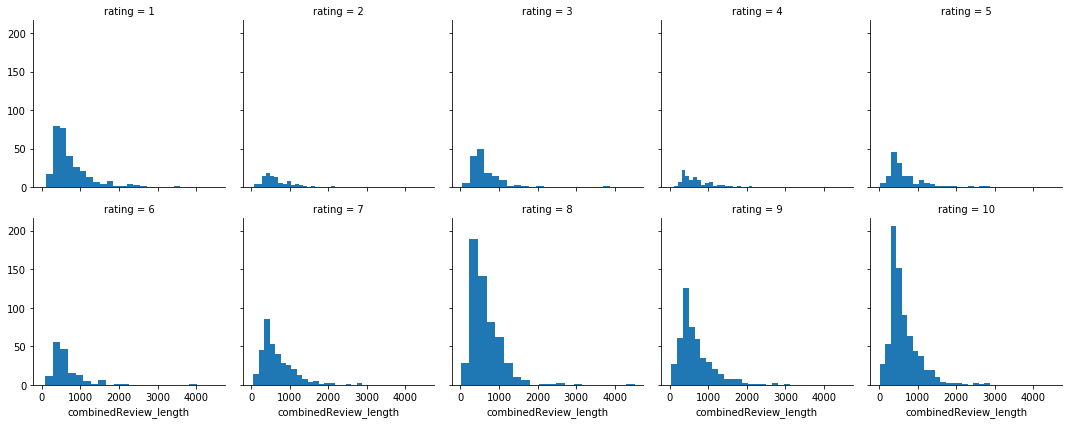

In [13]:
plt.rcParams['figure.figsize'] = [10, 5]

grid = sns.FacetGrid(data=training_df, col='rating', col_wrap=5)
grid.map(plt.hist, 'combinedReview_length', bins=20)

We can see that the distributions look similar across all the ratings with the amount of text accumulated in the higher ratings (>7). Most of the reviews tend to not exceed 1000 characters long. 

From the text length column, we then progress to plot the length of each review versus its rating. According to the plots above, we expect that the lowest rating and higher ratings contain the majority of the text. 

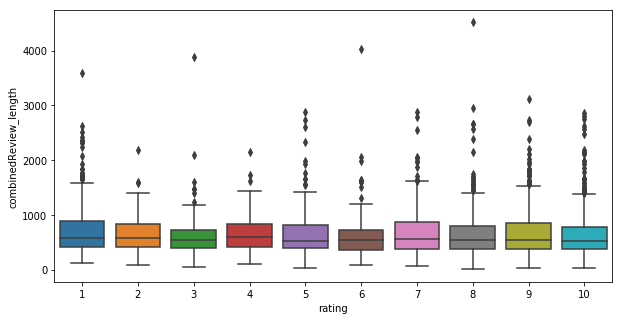

In [14]:
sns.boxplot(x='rating', y='combinedReview_length', data=training_df)

It seems like text length might not hold that much information for the ratings. As a result, we are not including this feature in the modelling. We could compare training with and without this feature but it will take additional investigations and is outside the scope of this project.

Next, we explore the distribution of the ratings to see which ratings are the most frequent. If the data is too skewed, it could affect our analysis.

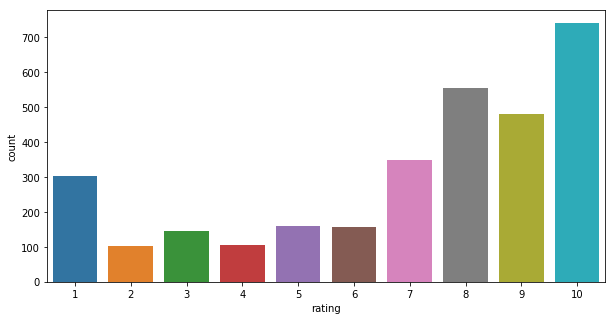

In [15]:
 rating = training_df.rating
sns.countplot(x=training_df.rating, data=training_df)

From the distribution above, we can see that it skews towards the higher ratings. One problem about this rating system with 1-10 points is that the classification between the adjacent scores such as 8 and 9. If the drug works well with little to no side effects, the patient might give 8, 9, or 10 without too much thought about it. Within a particular score region, it is entirely subjective. 

As a result, we can mitigate this problem by categorizing into 3 groups: 
- 1-3 for bad
- 4-7 for medium
- and 8-10 for good results. 

With this method, we reduce the noise of the data.

In [16]:
bins = [0,3.5,7.5,10] # the edges of the bins
labels = [1, 2, 3] # 1 = bad, 2 = medium, 3 = good
training_df['rating_binned'] = pd.cut(x=training_df['rating'], bins=bins, labels=labels)
test_df['rating_binned'] = pd.cut(x=test_df['rating'], bins=bins, labels=labels)

training_df[['urlDrugName', 'rating', 'rating_binned']]

,urlDrugName,rating,rating_binned
2202,enalapril,4,2
3117,ortho-tri-cyclen,1,1
...,...,...,...
2621,trileptal,8,3
2748,micardis,4,2


Let's also have a quick look at our feature space in the review description

In [17]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
X_vec = vectorizer.fit_transform(training_df['commentsReview'].values.astype('U'))
X_vec.shape

(3095, 121838)

In [18]:
# plotting first 20 for now, can be adjusted for investigation purposes
stopwords = list(vectorizer.get_stop_words())
stopwords[:20]

['perhaps',
 'down',
 'indeed',
 'rather',
 'less',
 'anyone',
 'find',
 'much',
 'his',
 'either',
 'etc',
 'should',
 'could',
 'somewhere',
 'thin',
 'whole',
 'whether',
 'into',
 'fifty',
 'him']

In [19]:
# plotting first 20 for now, can be adjusted for investigation purposes
features = vectorizer.get_feature_names()
features[:20]

['00',
 '00 10mgs',
 '00 10mgs 20mg',
 '00 75g',
 '00 75g dose',
 '00 month',
 '00 month periodic',
 '00 pm',
 '00 pm awake',
 '00 worth',
 '00 worth pills',
 '000',
 '000 mg',
 '000 mg brought',
 '000 mg day',
 '000 mgs',
 '000 mgs quite',
 '000 units',
 '000 units vit',
 '000mg']

## Data Modelling

First we use a "Decision Tree" on the effetiveness score and sideEffect score to predict the overall rating, to obtain a baseline for the F1-score and then we move on to NLP-based techniques

In [20]:
# import important packages from the nltk and sklearn library
! pip install mord
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import linear_model, metrics, preprocessing
from sklearn.metrics import classification_report
import mord
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten, Dropout, Add, Subtract, Multiply, Concatenate, Dot, Maximum
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM, Bidirectional
from keras.models import Model, Sequential

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Decision Tree
We neglect all of the review columns for now and use the one-hot encoded categorial columns 'urlDrugName' and 'condition' and label-encoded 'effectiveness' and 'sideEffects'. Decision tree method is chosen to be our first model because of its speed, easy-to-understand, simple-to-tune, and can be boosted by incorporate boosting techniques such as AdaBoost, or randomness in random forest method.

Decision trees generally give good results, are easy to implement, fast, and usually interprettable to a degree. The performance of decision tree method can also be improved by a number of techniques, random forest, AdaBoost, etc. 

We start with a simple decision tree classifier that takes 'urlDrugName', 'effectiveness', 'sideEffects', and	'condition' as inputs. Then, the rating results are rounded to the closest integers.

In [21]:
# concatenate dataframes
training_df_sliced = training_df[['effectiveness_encoded', 'sideEffects_encoded']]
test_df_sliced = test_df[['effectiveness_encoded', 'sideEffects_encoded']]

concat_training_df = pd.concat([training_df_sliced, training_df_drug_dm, training_df_cond_dm], axis=1)
concat_test_df = pd.concat([test_df_sliced, test_df_drug_dm, test_df_cond_dm], axis=1)


X_train = concat_training_df
y_train = training_df['rating_binned']

clf = DecisionTreeClassifier(max_depth=5) 
clf = clf.fit(X_train,y_train)

X_test = concat_test_df
y_test = test_df['rating_binned']
y_pred = clf.predict(X_test)

target_names = ['bad', 'medium', 'good']
print('Report:')
print(classification_report(y_test,y_pred, target_names=target_names))
print('R2 score: {}'.format(r2_score(y_test,y_pred)))

print('\n' + '##################################################' + '\n')

Report:
             precision    recall  f1-score   support

        bad       0.82      0.73      0.77       197
     medium       0.65      0.67      0.66       290
       good       0.87      0.89      0.88       549

avg / total       0.80      0.79      0.79      1036

R2 score: 0.6120699219664936

##################################################



From a simple decision tree with binned rating column, we get a pretty good f1-score at 0.79. From this point, we can probably fine tune it to reach 0.8 without a lof of effort. Lets now move on to some real NLP algorithms to make a review score predictor based on the text fields alone.

### NLP

Now, let's up NLP to analyse to dataset and compare the results with the f1-score we got from decision tree model. 

#### Text preprocessing

For text preprocessing, NLTK has much more features than SkLearn, so we use NLTK to do preprocessing and leave the training to SkLearn package.

1. Tokenization to separate into and words
    - the text is separated into works by space and period. Contractions such as 'don't' are treated as two words
2. Remove stop words such as 'a', 'an', 'the'
    - stop words do not contain meaningful information
3. Remove punctuations
4. Lemmatization to convert the words into their dictionary forms. Since the dataset is not large so we choose lemmatization over stemming. WordNetLemmatizer will look up a dictionary to find a dictionary form for each word.

In [22]:
# create new column
training_df['combinedReview_processed'] = training_df['combinedReview']

# tokenize
training_df['combinedReview_processed'] = training_df['combinedReview_processed'].apply(word_tokenize)

# remove stop words
stopwords_en = set(stopwords.words('english'))
training_df['combinedReview_processed'] = training_df['combinedReview_processed'].apply(lambda x: 
                                                                    [word for word in x if word not in stopwords_en])

# remove punctuations
punctuations = list(string.punctuation)
training_df['combinedReview_processed'] = training_df['combinedReview_processed'].apply(lambda x: 
                                                                    [word for word in x if word not in punctuations])

# lemmatization
lemmatizer = WordNetLemmatizer()
training_df['combinedReview_processed'] = training_df['combinedReview_processed'].apply(lambda x: 
                                                                                [lemmatizer.lemmatize(word) for word in x])

# do the same for test data
test_df['combinedReview_processed'] = test_df['combinedReview']
test_df['combinedReview_processed'] = test_df['combinedReview_processed'].apply(word_tokenize)
test_df['combinedReview_processed'] = test_df['combinedReview_processed'].apply(lambda x: 
                                                                                [word for word in x if word not in stopwords_en])
test_df['combinedReview_processed'] = test_df['combinedReview_processed'].apply(lambda x: 
                                                                                [word for word in x if word not in punctuations])
test_df['combinedReview_processed'] = test_df['combinedReview_processed'].apply(lambda x: 
                                                                                [lemmatizer.lemmatize(word) for word in x])

training_df.head(2)

,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview,combinedReview,effectiveness_encoded,sideEffects_encoded,combinedReview_length,rating_binned,combinedReview_processed
2202,enalapril,4,highly effective,mild side effects,management of congestive heart failure,slowed the progression of left ventricular dysfunction into overt heart failure alone or with other agents in the managment of hypertension mangagement of congestive heart failur,"cough, hypotension , proteinuria, impotence , renal failure , angina pectoris , tachycardia , eosinophilic pneumonitis, tastes disturbances , anusease anorecia , weakness fatigue insominca weakness","monitor blood pressure , weight and asses for resolution of fluid","slowed the progression of left ventricular dysfunction into overt heart failure alone or with other agents in the managment of hypertension mangagement of congestive heart failurcough, hypotension , proteinuria, impotence , renal failure , angina pectoris , tachycardia , eosinophilic pneumonitis, tastes disturbances , anusease anorecia , weakness fatigue insominca weaknessmonitor blood pressure , weight and asses for resolution of fluid",4,3,446,2,"[slowed, progression, left, ventricular, dysfunction, overt, heart, failure, alone, agent, managment, hypertension, mangagement, congestive, heart, failurcough, hypotension, proteinuria, impotence, renal, failure, angina, pectoris, tachycardia, eosinophilic, pneumonitis, taste, disturbance, anusease, anorecia, weakness, fatigue, insominca, weaknessmonitor, blood, pressure, weight, ass, resolution, fluid]"
3117,ortho-tri-cyclen,1,highly effective,severe side effects,birth prevention,"although this type of birth control has more cons than pros, it did help with my cramps. it's also effective with the prevention of pregnancy. (along with use of condoms as well)","heavy cycle, cramps, hot flashes, fatigue, long lasting cycles. it's only been 5 1/2 months, but i'm concidering changing to a different bc. this is my first time using any kind of bc, unfortunately due to the constant hassel, i'm not happy with the results.","i hate this birth control, i would not suggest this to anyone.","although this type of birth control has more cons than pros, it did help with my cramps. it's also effective with the prevention of pregnancy. (along with use of condoms as well)heavy cycle, cramps, hot flashes, fatigue, long lasting cycles. it's only been 5 1/2 months, but i'm concidering changing to a different bc. this is my first time using any kind of bc, unfortunately due to the constant hassel, i'm not happy with the results.i hate this birth control, i would not suggest this to anyone.",4,1,498,1,"[although, type, birth, control, con, pro, help, cramp, 's, also, effective, prevention, pregnancy, along, use, condom, well, heavy, cycle, cramp, hot, flash, fatigue, long, lasting, cycle, 's, 5, 1/2, month, 'm, concidering, changing, different, bc, first, time, using, kind, bc, unfortunately, due, constant, hassel, 'm, happy, results.i, hate, birth, control, would, suggest, anyone]"


### Multimodal Naive Bayes

In a bag-of-word model, which is the model we will use, we treat words in no orders like pouring all of the words into a bag. This means that we consider the frequency of word appearance instead of word order. There are several way to count word frequency but we will use the most basic one: count vectorization. It has been shown that Multimodal Navie Bayes classifier works well within text classification and is also common amongst spam email detection. 

In [23]:
# join the lists in the column together
training_df['combinedReview_processed'] = training_df['combinedReview_processed'].apply(lambda x: " ".join(x))
test_df['combinedReview_processed'] = test_df['combinedReview_processed'].apply(lambda x: " ".join(x))

# since the data is already cleaned, we do not need to do it here
vectorizer = CountVectorizer(lowercase=False, preprocessor=None, tokenizer=None, stop_words=None, ngram_range=(1,3))
X_train = training_df['combinedReview']
X_test = test_df['combinedReview']
y_train = training_df['rating_binned']
y_test = test_df['rating_binned']

# fit (learn vocaburary) and transform the training data
X_train = vectorizer.fit_transform(X_train)

# transform the test data
X_test = vectorizer.transform(X_test)

# make a classifier
clf = MultinomialNB(alpha=.1)

# train the classifier
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

target_names = ['bad', 'medium', 'good']
print(classification_report(y_test, y_pred, target_names=target_names))
print('\n' + '##################################################' + '\n')


             precision    recall  f1-score   support

        bad       0.68      0.40      0.50       197
     medium       0.52      0.18      0.27       290
       good       0.62      0.93      0.75       549

avg / total       0.61      0.62      0.57      1036


##################################################



### Logistic Regression
Lets use the feature vector extracted from the text with TfidfVectorizer, discussed in the 'Data Explonatory' section of this notebook. Then we can use e.g. logistic regression in a machine learning pipeline to predict the review score.

In [24]:
# logistic regression
X = training_df['combinedReview']
Y = training_df['rating_binned']
Y_test = test_df['rating_binned']
X_test = test_df['combinedReview']

pipeline = Pipeline([
                    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1,2))),
                    ('clf', linear_model.LogisticRegression(
                                solver='lbfgs',
                                multi_class='multinomial'))
                ])
model = pipeline.fit(X, Y)

print("Logistic Regression")
print(classification_report(Y_test, model.predict(X_test)))


Logistic Regression
             precision    recall  f1-score   support

          1       0.86      0.21      0.34       197
          2       0.81      0.07      0.13       290
          3       0.57      0.99      0.72       549

avg / total       0.69      0.59      0.48      1036



### Deep Learning with TensorFlow/Keras
Now its time to use a deep learning model based on the powerfull TensorFlow engine with Kera - a high-level API.

First step is to perform a one-hot encoding of the ratings;

In [25]:
# Define one-hot encoding "y" for Training/Validation 
y = pd.get_dummies(training_df['rating_binned']).values
y2 = pd.get_dummies(test_df['rating_binned']).values

# Define for Tests
y_test_predicted = pd.get_dummies(test_df['rating_binned']).values

print ('Score Encoding: \n', y[1:10])
print ('Raw comments: \n', training_df.commentsReview[1:10])

Score Encoding: 
 [[1 0 0]
 [0 0 1]
 [1 0 0]
 ...
 [0 0 1]
 [0 0 1]
 [1 0 0]]
Raw comments: 
 3117    i hate this birth control, i would not suggest this to anyone.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [26]:
train_df_processed = pd.DataFrame(y)
train_df_processed[3] = list(training_df['combinedReview_processed'])
train_df_processed.head(10)
test_df_processed = pd.DataFrame(y2)
test_df_processed[3] = list(test_df['combinedReview_processed'])
test_df_processed.head(10)

,0,1,2,3
0,0,0,1,antibiotic may destroyed bacteria causing sinus infection may also caused virus hard say.some back pain nauseau.took antibiotic 14 day sinus infection gone 6th day
1,0,0,1,lamictal stabilized serious mood swing one minute clawing wall pure mania next curled fetal position bed contemplating suicdie longer whim mood neither around 'm lucky started pharmaceutical almost immediately diagnosed bipolar lamictal give amazing clarity go day honestly ass form real relationship lamitcal lifted fog guess could call 'm medicated realize cloudy thought process used 's wonderful feeling interestingly hardly dreamt beginning lamictal would dream mean dream sense able imagine picture scene asleep rem maybe every two month dream every night found closer take bedtime frequent intense dreams.drowsiness bit mental numbness take much feel sedated since able clearly honestly ass emotion thought determining much medication need tough found 400mg work perfectly 's high dose le feel medicine wearing prematurely like last 24hrs sleep sleep feel numb might call drowsiness 's sluggishness mind began treating bipolar disorder used write fair amount fiction sort flowed definitely artist 's temperament lamictal though inherent creativity fizzled n't come spilling 'm deep manic euphoria work art 's something requires discipline field requires creativity expect see change output.severe mood swing hypomania depression suicide ideation lamictal began 10mg tritrated 400mg month played around dosage finally arrive 400mg experimented taking different time evening found comfortable time sleep
...,...,...,...,...
8,0,0,1,immediately stopped panic attack really miraculous becoming frequent severe combination klonopin prozac experienced panic attack 10 year simply feel `` normal '' able go day without feeling extreme nausea dizziness panic attack manifested longer leave work early avoid restaurant supermarket worry getting suddenly `` sick '' reason.i experienced side effect tired feel medicated.i started klonopin prozac together first took klonopin 4 time day gradually able cut back twice day first thing morning dinnertime gradually cutting first noontime dosage bedtime one never talk-therapy continue take klonopin generic clonazapam day adverse reaction
9,1,0,0,presumed benefit help severe depression beginning benefit ie le suicidal apathetic morbid depressed effect short lived dose continually increased biggest benefit probably placebo feeling like getting help hopeful trusting treatment doctors.here go.the initial effect would dry mouth sleepiness able think straight function really dose would acclimatised would okay also cased hypo hypersomnia shakiness time large cognitive deficit reading comprehension eye would literally\ physically play trick seeing word substituting others blind spot general confusion knowing going.nightmares nightsweatsfamily doctor initially prescribed wellbutin psychologist hospital suggested effexor dose would increased would adjust experience setback gabapentin added sleep trouble augment many thing also added subtracted avail psychiatrist felt dose could increased 375 mg. supervised care family physician side effect caused sent specialist specialist tentative diagnosis ranging borderline personality narcolepsy modifinil sleep apnea restless leg finally bi polar finally different psychiatrist said drug


In [27]:
post_processed_train_comments = train_df_processed[3].tolist()
post_processed_y = train_df_processed[[0, 1, 2]].values
post_processed_test_comments = test_df_processed[3].tolist()
post_processed_y2 = test_df_processed[[0, 1, 2]].values

In [28]:
# Tokenize the data
MAX_NB_WORDS = 3000
tokenizer = Tokenizer(num_words = MAX_NB_WORDS, 
                      filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',
                      lower=True, split=' ', char_level=False, 
                      oov_token=None, document_count=0)

tokenizer.fit_on_texts(post_processed_train_comments + post_processed_test_comments)

In [29]:
MAX_SEQUENCE_LENGTH = 100

# Convert to sequences
train_sequences = tokenizer.texts_to_sequences(post_processed_train_comments)
test_sequences = tokenizer.texts_to_sequences(post_processed_test_comments)
word_index = tokenizer.word_index
print('found %s tokens in text.' %(len(word_index)))

# Ensure all sequences have the same length (=3000). 
train_data = pad_sequences(train_sequences, maxlen = MAX_SEQUENCE_LENGTH)
final_test_data = pad_sequences(test_sequences, maxlen = MAX_SEQUENCE_LENGTH)

# Print shapes of data. 
print(train_data.shape, '<-- shape of train_data ready for val/train split.')
print(final_test_data.shape, '<-- shape of final_test_data ready for fedding to network.')
print(len(word_index), '<-- Length of Word Index')

found 16430 tokens in text.
(3095, 100) <-- shape of train_data ready for val/train split.
(1036, 100) <-- shape of final_test_data ready for fedding to network.
16430 <-- Length of Word Index


Now the dataset is split into a training and test data set for validation purposes.

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(train_data, post_processed_y,
                                                  test_size = 0.2,  stratify= post_processed_y, 
                                                  random_state = 2019)
X_test = final_test_data
Y_test = y_test_predicted

print('train data shape:', X_train.shape)
print('validation data shape:', X_val.shape)

train data shape: (2476, 100)
validation data shape: (619, 100)


Values for the embedding value and sequence length are defined. Then the Keras model is built by adding layers to a neural network.

In [31]:
EMBEDDING_DIM = 160
nb_words  = min(MAX_NB_WORDS, len(word_index))
lstm_out = MAX_SEQUENCE_LENGTH

# The keras model is constructed
model = Sequential()
model.add(Embedding(nb_words, EMBEDDING_DIM, input_length=lstm_out))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(3, activation = 'softmax'))

# compiled with a loss function and an optimizer, with a metric called 'accuracy'
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 160)          480000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 160)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               104400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 584,703
Trainable params: 584,703
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Early stopping is applied to the Model Checkpoints of the Keras model to get an optimal model train vs validation accuracy
early_stopping = EarlyStopping(patience = 4)
model_checkpoint = ModelCheckpoint('model_best.h5', save_best_only = True)

batch = 32
# Run LSTM Model
epoch = 100
LSTM_model = model.fit(X_train, Y_train, batch_size=batch, epochs=epoch,
                       validation_data=(X_val, Y_val), shuffle = True, 
                       callbacks = [early_stopping, model_checkpoint], verbose = 0)
best_score = min(LSTM_model.history['val_loss'])

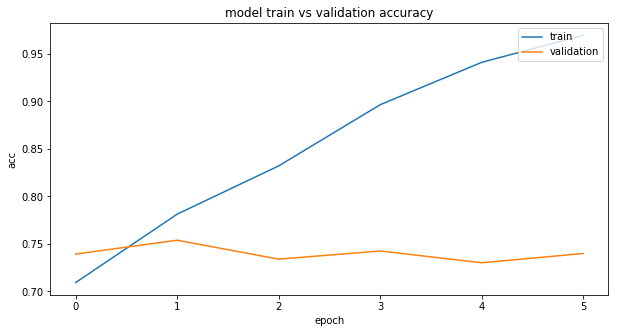

In [33]:
# plotting og model train vs validation accuract
plt.plot(LSTM_model.history['acc'])
plt.plot(LSTM_model.history['val_acc'])
plt.title('model train vs validation accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [34]:
accr = model.evaluate(X_test, Y_test, batch_size = 256)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1036/1036 [==============================] - 0s 392us/step
Test set
  Loss: 1.123
  Accuracy: 0.701


Training curve above looks very stable for validation test set whereas it keeps increasing for training set. It looks like we are overfitting to the training set - but accuracy is no matter around 70 %.

## Score Predictor based on Reviews

Tried for a few test examples

In [35]:
def Predictor(string):
    pred = pd.DataFrame()
    pred['review'] = [string]
    pred['review'] = pred['review']
    pred['review'] = pred['review'].apply(word_tokenize)
    pred['review'] = pred['review'].apply(lambda x: [word for word in x if word not in stopwords_en])
    pred['review'] = pred['review'].apply(lambda x: [word for word in x if word not in punctuations])
    pred['review'] = pred['review'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    pred['review'] = pred['review'].apply(lambda x: " ".join(x))
    post_processed_train_comments = list(pred['review'])
    train_sequences = tokenizer.texts_to_sequences(post_processed_train_comments)
    strvec = pad_sequences(train_sequences, maxlen = MAX_SEQUENCE_LENGTH)
    a = model.predict(strvec)
    print("Prediction for Sentence '{}' is: \n Good: {} \n Medium: {} \n Bad: {} \n \n".format(string, a[0][2],  a[0][1],  a[0][0]))
    
Predictor("Worst medicine I have ever taken")
Predictor("I really love this medicine")
Predictor("This completely cured me from my desease")
Predictor("I hate to take this medicine")

Prediction for Sentence 'Worst medicine I have ever taken' is: 
 Good: 0.07709410786628723 
 Medium: 0.010143773630261421 
 Bad: 0.9127621054649353 
 

Prediction for Sentence 'I really love this medicine' is: 
 Good: 0.9845934510231018 
 Medium: 0.007018466014415026 
 Bad: 0.008388112299144268 
 

Prediction for Sentence 'This completely cured me from my desease' is: 
 Good: 0.9033885598182678 
 Medium: 0.036826152354478836 
 Bad: 0.05978522449731827 
 

Prediction for Sentence 'I hate to take this medicine' is: 
 Good: 0.3706110715866089 
 Medium: 0.0686618909239769 
 Bad: 0.560727059841156 
 



## Summary

We notice that the rating is evaluated from 1 to 10 and the scale is subjected to personal bias and noise. There could be no reason for a person to give a 8 instead of 9 or 10 if the drug works well. Consequently, the 'rating' column is grouped into 3 simple bins: bad, medium, and good results. This helps us a lot in categorization and improves the performance.

The models can also be improved by tuning the parameters by utilizing grid search to find the optimal points. However, without tuning, the performance for decision tree is at around 0.80 based on the one-hot encoding of effectiveness and sideeffect scores which is quite good and a baseline for the review score predicter. Count vectorization and multimodal naive Bayes of the actually text gives us a review score predictor with a f1-score of 0.40 and 0.57 respectively. A model based on Deep Learning and TensorFlow/Keras gave an accuracy of 80 %. We are starting to get nearer to something useful.

Next step might to look at performance for a 2-step score predictor, instead of the 3-step predictor investigated in this project. That also depends on the stakeholders

## What can we improve?

1. Use pipeline in sklearn to turn all the steps into streamlined DAG process
2. Tune the parameters by grid search
3. Use Random forests or boosting techniques to increase decision tree performance
4. Clean up the data more by removing numbers
5. Use other word counting techniques such as TF-IDF
6. Fine tune the parameters such as n-gram, etc.